In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import os
import seaborn as sns
import ratmetab
if os.getlogin() == 'jonesa7':
    import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = ratmetab.read_all_data()
data['brain']

,LIscore,Group,Cholic acid,Taurocholic acid,Taurochenodeoxycholic acid,Tauromuricholic acid (alpha + beta),Carnitine,Acetylcarnitine,Propionylcarnitine,Malonylcarnitine (Hydroxybutyrylcarnitine),...,Dihydroceramide C10:1,Ceramide C14:0,Ceramide C15:1,2-Hydroxyacylceramide C20:0,2-Hydroxyacyldihydroceramide C28:0,Phosphatidylethanolamine aa 20:0,Phosphatidylethanolamine aa 22:2,Phosphatidylethanolamine ae 38:2,Phosphatidylethanolamine ae 42:1,Phosphatidylserine aa 40:5
idno,,,,,,,,,,,,,,,,,,,,,
105,249,AI,NaN,NaN,NaN,NaN,11.034,1.521,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1158,201,AU,NaN,0.32700,0.03300,0.27960,10.904,4.107,0.142000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1172,155,AU,NaN,0.37800,0.01784,0.21040,10.132,4.187,0.072465,0.060798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1174,194,AU,NaN,0.14600,NaN,0.06520,10.024,4.249,0.146000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,291,AI,NaN,NaN,NaN,NaN,11.611,3.001,NaN,0.077633,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,200,Y,NaN,0.05720,0.01228,0.08160,41.726,10.425,NaN,0.296000,...,NaN,0.01079,NaN,0.11100,0.0084,0.108,0.199,0.476,0.562,39.963
298,212,Y,0.0544,0.02564,0.01232,0.02828,40.899,10.093,NaN,0.258000,...,NaN,0.00782,NaN,0.07611,NaN,0.100,0.175,0.364,0.390,NaN
427,218,Y,NaN,0.11200,NaN,0.03304,44.390,7.729,NaN,0.216000,...,0.00094,0.01136,NaN,0.05706,NaN,0.393,0.348,NaN,0.586,44.008


In [3]:
codebookpath = '../../resources/rat-metabolites/Rat_codebook_27_Oct_2022.csv'
def sort_data(df, codebookpath=codebookpath):
    df = df.sort_values(['Group', 'LIscore'])
    codebook = pd.read_csv(codebookpath, index_col='MetaboliteName')
    s = codebook.loc[df.columns[2:], 'AnalyteClass']
    level0 = ['Subject'] * 2 + s.to_list()
    level1 = df.columns[:2].to_list() + s.index.to_list()
    df.columns = pd.MultiIndex.from_arrays([level0, level1])
    A = df.iloc[:, :2]
    B = df.iloc[:, 2:]
    B = B.sort_index(axis=1, level=[0, 1])
    df = pd.concat([A, B], axis=1)
    return(df)

def standardize(df, dropna=False, fillna=True):
    #df = data[dataset]
    #df = df.sort_values(['Group', 'LIscore'])
    df = df.iloc[:, 2:].transpose()
    std_df = df.apply(lambda x: (x - df.mean(axis=1)) / df.std(axis=1), axis=0)
    std_df = std_df.dropna(axis=0) if dropna else std_df
    std_df = std_df.fillna(0) if fillna else std_df
    return(std_df)

def make_col_colors(std_df, dataset, data=data):
    df = data[dataset]
    group2color = pd.Series(['C0', 'C1', 'C2'], index=['Y', 'AI', 'AU'])
    #group2color = pd.Series(['tab:blue', 'tab:orange', 'tab:green'], index=['Y', 'AI', 'AU'])
    col_colors = group2color.loc[[df.Group.loc[idno] for idno in std_df.columns]]
    return((col_colors, group2color))

def make_row_colors(std_df, codebookpath=codebookpath, min_saturation=0.15):
    codebook = pd.read_csv(codebookpath, index_col='MetaboliteName')
    t = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name) for name, color in mcolors.CSS4_COLORS.items())
    t = (x for x in t if x[0][1] >= min_saturation)
    colors = list(x[1] for x in t)
    aclasses = np.unique(codebook.AnalyteClass)
    aclass2color = pd.Series(colors[:: -np.int16(np.ceil(len(colors) / len(aclasses)))], index=aclasses)
    row_colors = codebook.loc[std_df.index.get_level_values(1), 'AnalyteClass'].apply(lambda x: aclass2color.loc[x])
    #row_colors = codebook.loc[std_df.index, 'AnalyteClass'].apply(lambda x: aclass2color.loc[x])
    return((row_colors, aclass2color))

In [4]:
def my_legend(g, x2color, title='Analyte class', loc='center left', bbox_to_anchor=(-0.3, 0.25, 0.5, 0.5), ncol=1):
    colors = x2color.to_list()
    handles = [mpatches.Patch(color=c) for c in colors]
    labels = x2color.index
    g.legend(handles, labels, title=title, loc=loc, bbox_to_anchor=bbox_to_anchor, ncol=ncol)
    return(g)

def my_clustermap(dataset, row_cluster=False, col_cluster=False, dropna=False, fillna=True, cmap='bwr', codebookpath=codebookpath):
    df = data[dataset]
    df = sort_data(df, codebookpath=codebookpath)
    std_df = standardize(df, dropna=dropna, fillna=fillna)
    row_colors, aclass2color = make_row_colors(std_df)
    col_colors, group2color = make_col_colors(std_df, dataset)
    vmax = std_df.abs().max().max()
    g = sns.clustermap(std_df, row_colors=row_colors.to_list(), col_colors=col_colors.to_list(),
                       cmap=cmap, row_cluster=row_cluster, col_cluster=col_cluster, vmin=-vmax, \
                       vmax=vmax, cbar_pos=(0.95, 0.35, 0.05, 0.3), xticklabels='', yticklabels='', figsize=(6, 9))
    my_legend(g.fig, aclass2color, title='Analyte class', loc='center left', bbox_to_anchor=(-0.3, 0.25, 0.5, 0.5))
    my_legend(g.fig, group2color.sort_index(), title='Rat group', loc='lower center', bbox_to_anchor=(0.35, 0.8, 0.5, 0.1), ncol=3)
    g.ax_heatmap.set_xlabel('')
    g.ax_heatmap.set_ylabel('')
    g.ax_cbar.set_ylabel('std. metabolite level')
    return(g)

## Brain (old + new data)
### Heatmap (impute missing metab. levels)

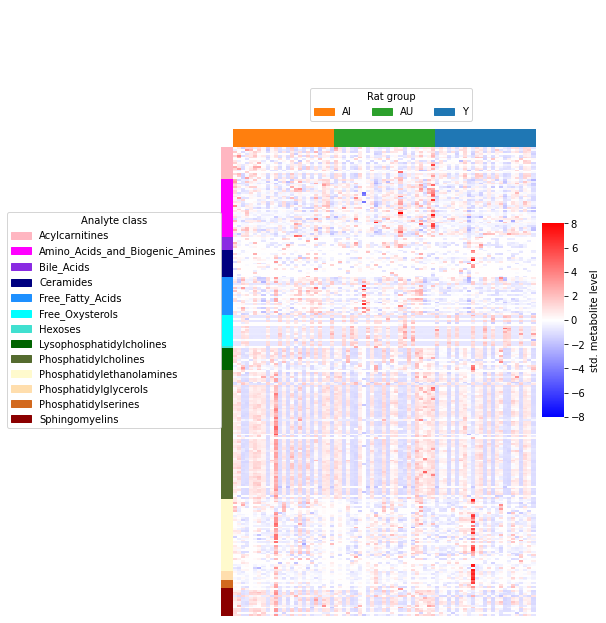

In [5]:
g = my_clustermap('brain')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(g.fig, 'heatmap-brain')

### Heatmap: drop metabolites with missing values

This drops most metabolites since most of them contain at least one missing value across all 75 rat subjects in the merged (new + old) data set.

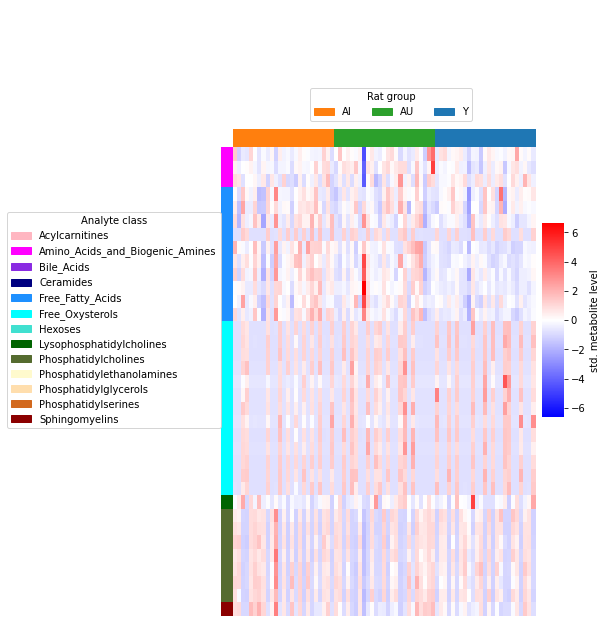

In [6]:
g = my_clustermap('brain', dropna=True, fillna=False)
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(g.fig, 'heatmap-brain-dropna')

### Clustermap

We see a meaningful clustering of metabolites: metabolites in the same Analyte class tend to cluster together.

/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


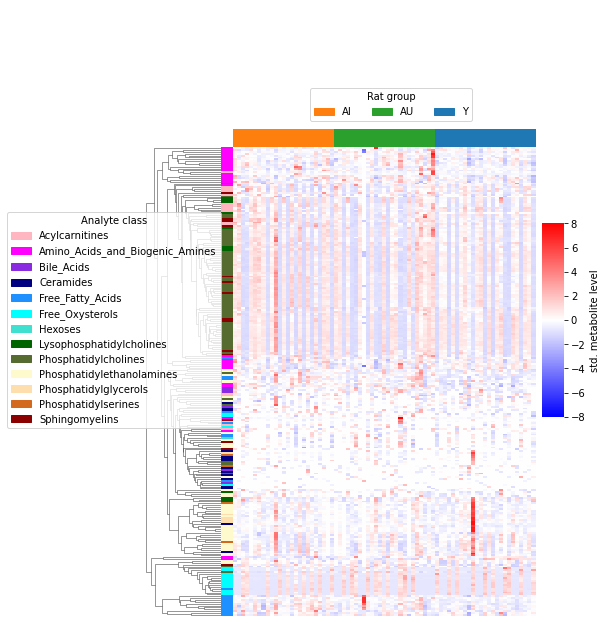

In [7]:
g = my_clustermap('brain', row_cluster=True, col_cluster=False)
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(g.fig, 'clustermap-brain')

## Blood (old + new data)
### Heatmap (impute missing metab. levels)

The blood based results reveal widespread difference between young (Y) and aged (AI and AU) animals across many metabolites.  No clear difference is seen between AI and AU, however.

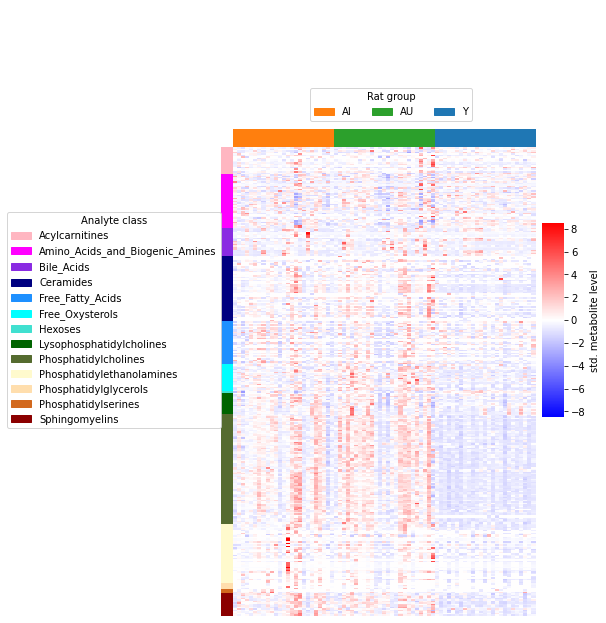

In [8]:
g = my_clustermap('blood', row_cluster=False, col_cluster=False)
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(g.fig, 'heatmap-blood')

### Clustermap

/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


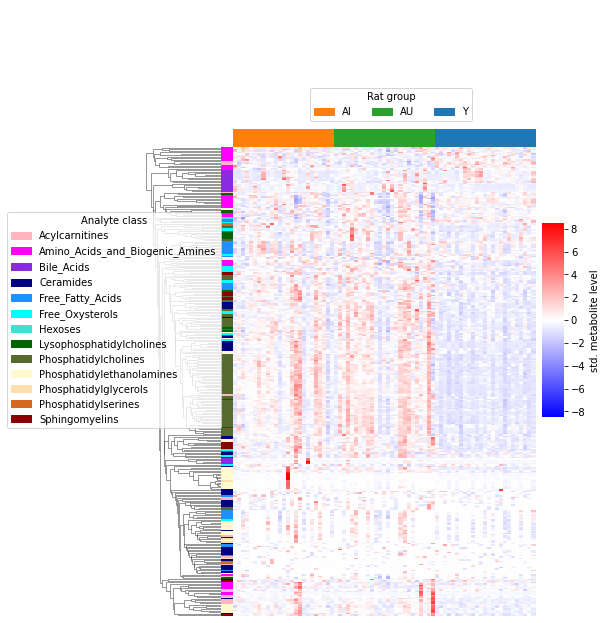

In [9]:
g = my_clustermap('blood', row_cluster=True, col_cluster=False)
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(g.fig, 'clustermap-blood')

### Clustering rat subjects

Young rats tend to segregate from AU and AI rats.  AU rats are mixed with AI rats in larger clusters.  Some  smaller clusters show similar mixed AU/AI pattern, while other smaller clusters are not mixed (segregation).  This leaves the question open whether there are metabolic differences between AU and AI.

/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


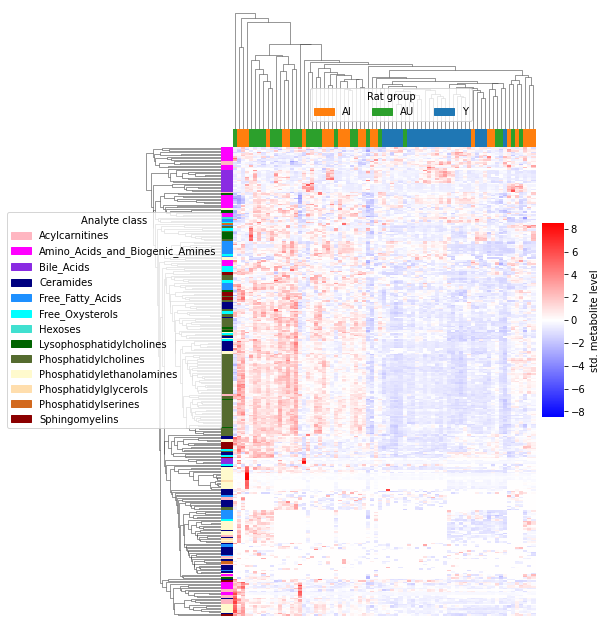

In [10]:
g = my_clustermap('blood', row_cluster=True, col_cluster=True)
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(g.fig, '2way-clustermap-blood')

In [11]:
%connect_info

{
  "shell_port": 62280,
  "iopub_port": 62281,
  "stdin_port": 62282,
  "control_port": 62284,
  "hb_port": 62283,
  "ip": "127.0.0.1",
  "key": "33122b04-5d3b121d4dd4f1f0c8009ff8",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-4011cf43-a468-440d-9c3a-f1f2acd4ed48.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
